In [2]:
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv('./dataset/org/H1_nav.csv')
df.head()
drop = ['Participant', 'Dataset', 'ViewFrame']
df.drop(drop, inplace =True, axis = 1)

In [4]:
df.head()
df.shape
df = torch.Tensor(df.values)

In [5]:
V = df[:,0]
X = df[:,1]
Y = df[:,2]
Z = df[:,3]
Pitch = df[:,4]
Roll = df[:,5]
Yaw = df[:,6]

In [6]:
def clean(d, p):
    data = []
    for i in range(0,int(np.ma.count(d)/p)):
        if(np.ma.count(d) < i*p):
            n = (d[-1] - d[(i*p)])/(np.ma.count(d) - (i*p))
            data.append(n)
        else:
            n = (d[(i*p) + p - 1] - d[(i*p)])/p
            data.append(n)
    return data

In [7]:
def plot(x, y, z, yaw, pitch, roll, n):
    x1 = clean(x,n)
    y1 = clean(y,n)
    z1 = clean(z,n)
    yaw1 = clean(yaw, n)
    pitch1 = clean(pitch, n)
    roll1 = clean(roll, n)

    plt.figure(1)
    plt.plot(x1, label = 'X')
    plt.plot(y1, label = 'Y')
    plt.plot(z1, label = 'Z')
    plt.title("Body Motion Speed")
    plt.legend()
    plt.savefig("BodyMotion.jpg", dpi=200)

    plt.figure(2)
    plt.plot(yaw1, label = 'yaw')
    plt.plot(pitch1, label = 'pitch')
    plt.plot(roll1, label = 'roll')
    plt.title("Head Motion Speed")
    plt.legend()
    plt.savefig("HeadMotion.jpg", dpi=200)

In [8]:
def data(data, step=1):
    x_d, y_d = [], []
    for i in range(len(data)-step-1):
        a = data[i:(i+step), 0]
        x_d.append(a)
        y_d.append(data[i + step, 0])
    return np.array(x_d), np.array(y_d)

In [9]:
def process(n, step = 125):
    set=n.reshape(-1, 1)
    train_size = int(len(set) * 0.9)
    test_size = len(set) - train_size
    train, test = set[0:train_size,:], set[train_size:len(set),:]

    x_train, y_train = data(train, step)
    x_test, y_test = data(test, step)
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).float()
    return x_train, y_train, x_test, y_test

In [10]:
class lstm(nn.Module):
    def __init__(self, hidden_layers=32, numLayers = 1):
        super(lstm, self).__init__()
        self.hidden_layers = hidden_layers
        self.numLayers = numLayers
        self.lstm1 = nn.LSTM(125, self.hidden_layers, batch_first=True, num_layers = numLayers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, inputVal):
        hidden_state = torch.randn(self.numLayers, inputVal.size(0), 32).float()
        cell_state = torch.randn(self.numLayers, inputVal.size(0), 32).float()
        hidden = (hidden_state, cell_state)
        h_t, c_t = self.lstm1(inputVal.float(), hidden)
        outputs = self.linear(h_t) 
        return outputs



In [11]:
def train(n_epochs, model, optimiser, loss_fn, train_input, train_target):
    model.train()
    trainLoss = []
    train_target = train_target.reshape(train_target.size(0), 1, 1)
    for i in range(n_epochs):
        optimiser.zero_grad()
        out = model(train_input)
        loss = loss_fn(out, train_target)
        loss.backward()    
        optimiser.step()
        trainLoss.append(loss)
        print("Step: {}, Loss: {}".format(i, loss))
    return trainLoss

def eval(model, loss_fn, test_input, test_target):
        model.eval()
        test_target = test_target.reshape(test_target.size(0), 1, 1)
        with torch.no_grad():
            pred = model(test_input)
            loss = loss_fn(pred, test_target)
            return loss, pred

In [12]:
def train_a(epoch, model, optimiser, criterion, x_train, y_train, path, n):
    model = model.float()
    train_loss = train(epoch, model, optimiser, criterion, x_train, y_train)
    l = []
    for i in range(0,len(train_loss)):
        l.append(train_loss[i].item())
    plt.plot(l, label = "Training Loss")
    plt.legend()
    plt.savefig(path+n+"train_loss.jpg", dpi=200)
    plt.close()


In [13]:
def eval_a(model, criterion, x_test, y_test, path, n):
    test_loss, prediction = eval(model, criterion, x_test, y_test)
    print(test_loss.item())
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(y_test, prediction.reshape(prediction.size(0)))
    plt.xlabel("Actual Value")
    plt.ylabel("Predicted Value")
    plt.savefig(path+n+"p.jpg", dpi=200)
    plt.close()

In [14]:
for i in range(1,2):
    n = r"dataset/H" + str(i) +  ".csv"
    path = r"dataset/H" + str(i) + "_nav/"
    file = r"dataset/H" + str(i) + "_nav/plots/"
    df = pd.read_csv (n)
    
    for (i, j) in df.iteritems():
        print("Predicting for " + i)
        c = df[i].to_numpy()
        t_x, t_y, e_x, e_y = process(c)
        
        model = lstm(numLayers = 10)
        criterion = nn.MSELoss()
        optimiser = optim.Adam(model.parameters(), lr=0.01)
        train_a(100, model, optimiser, criterion, t_x, t_y,file,i)
        torch.save(model.state_dict(), path+i+"savedModel.pt")
        eval_a(model, criterion, e_x, e_y, file, i)



Predicting for HMDPX
Step: 0, Loss: 0.21147295832633972
Step: 1, Loss: 0.20975081622600555
Step: 2, Loss: 0.20657749474048615
Step: 3, Loss: 0.20594775676727295
Step: 4, Loss: 0.20281396806240082
Step: 5, Loss: 0.20215438306331635
Step: 6, Loss: 0.20063722133636475
Step: 7, Loss: 0.20011642575263977
Step: 8, Loss: 0.19931915402412415
Step: 9, Loss: 0.19846150279045105
Step: 10, Loss: 0.19888874888420105
Step: 11, Loss: 0.1985313594341278
Step: 12, Loss: 0.19794897735118866
Step: 13, Loss: 0.1981106400489807
Step: 14, Loss: 0.19769778847694397
Step: 15, Loss: 0.19795769453048706
Step: 16, Loss: 0.19808606803417206
Step: 17, Loss: 0.19783401489257812
Step: 18, Loss: 0.19800032675266266
Step: 19, Loss: 0.19803401827812195
Step: 20, Loss: 0.19785621762275696
Step: 21, Loss: 0.19802841544151306
Step: 22, Loss: 0.1980084925889969
Step: 23, Loss: 0.19789375364780426
Step: 24, Loss: 0.19782114028930664
Step: 25, Loss: 0.19778913259506226
Step: 26, Loss: 0.19802260398864746
Step: 27, Loss: 0.19

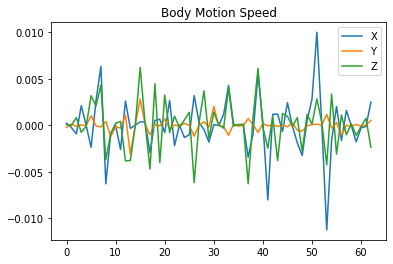

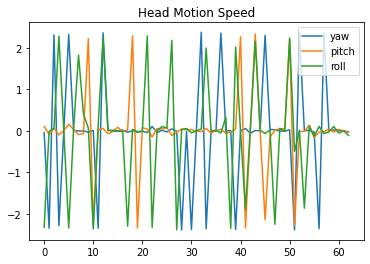

In [18]:
df = pd.read_csv (r"/home/arty/Desktop/NYU Spring 2022/6DOF/dataset/H1.csv")

X = df['HMDPX'].to_numpy()
Y = df['HMDPY'].to_numpy()
Z = df['HMDPZ'].to_numpy()
Yaw = df['HMDRZ'].to_numpy()
Pitch = df['HMDRX'].to_numpy()
Roll = df['HMDRY'].to_numpy()

plot(X, Y, Z, Yaw, Pitch, Roll, 150)

